In [464]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report,ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from scipy.stats import entropy
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
import random
import graphviz
from sklearn import tree
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier



In [465]:
def SmoothBinBoundaries(val,min,max):
  newVal=None
  if (val-min)>(max-val):
    newVal=max
  else :
    newVal=min
  return newVal

In [466]:
def minMax(df,columns_to_normalize):
  min_max_scaler = MinMaxScaler(feature_range=(0, 10))
  df_min_max = df.copy()
  df_min_max[columns_to_normalize] = min_max_scaler.fit_transform(df[columns_to_normalize])
  return df_min_max

In [467]:
def ZScore(df,columns_to_normalize):
  zscore_scaler = StandardScaler()
  df_zscore = df.copy()
  df_zscore[columns_to_normalize] = zscore_scaler.fit_transform(df[columns_to_normalize])
  return df_zscore

In [468]:
def decimalPoint(df,columns_to_normalize):
  df_decimal = df.copy()
  for column in columns_to_normalize:
    df_decimal[column] = df[column] / 10**(len(str(df_decimal[column].max())))
  return df_decimal

In [469]:
def BinBoundaries(df,columns_to_normalize,num_bins):
  df_bin_boundaries = df.copy()
  for column in columns_to_normalize:
    df_sorted = df_bin_boundaries.sort_values(column)  # Sort the DataFrame by the 'Values' column
    bin_size = len(df_sorted) // num_bins  # Determine the size of each bin
    bin_boundaries = []
    bins = []
    for i in range(num_bins):
      if i == num_bins - 1:
          bin_boundary = [df_sorted.iloc[i * bin_size][column], df_sorted.iloc[-1][column]]
          bin = df_sorted.iloc[i * bin_size:].copy()
      else:
          bin_boundary = [df_sorted.iloc[i * bin_size][column], df_sorted.iloc[(i + 1) * bin_size - 1][column]]
          bin = df_sorted.iloc[i * bin_size: (i + 1) * bin_size].copy()

      bin[column] = np.where(np.abs(bin[column] - bin_boundary[0]) < np.abs(bin[column] - bin_boundary[1]),
                              bin_boundary[0], bin_boundary[1])

      bin_boundaries.append(bin_boundary)
      bins.append(bin)
    df_bins = pd.concat(bins).sort_index()
    df_bin_boundaries[column]=df_bins[column]
  return df_bin_boundaries


In [470]:
def BinMeans(df,columns_to_normalize,num_bins):
  df_bin_means = df.copy()
  for column in columns_to_normalize:
      bins = pd.qcut(df[column], q=num_bins, duplicates='drop')
      df_bin_means[column] = df.groupby(bins)[column].transform('mean')
  return df_bin_means

In [471]:
df = pd.read_csv('NY Realstate Pricing.csv')
df

,F1,id,neighbourhood,latitude,longitude,room_type,price,days_occupied_in_2019,minimum_nights,number_of_reviews,reviews_per_month,availability_2020
0,0,2595,Midtown,40.75362,-73.98377,Entire home/apt,225,15,10,48,0.39,1
1,1,3831,Brooklyn,40.68514,-73.95976,Entire home/apt,89,188,1,295,4.67,1
2,2,5099,Manhattan,40.74767,-73.97500,Entire home/apt,200,362,3,78,0.60,19
3,3,5121,Bedford-Stuyvesant,40.68688,-73.95596,Private room,60,0,29,49,0.38,365
4,4,5178,Manhattan,40.76489,-73.98493,Private room,79,141,2,454,3.52,242
...,...,...,...,...,...,...,...,...,...,...,...,...
17609,28313,23691588,Brooklyn,40.69312,-73.94073,Shared room,32,9,31,5,0.26,1
17610,17415,14712466,Brooklyn,40.65446,-73.92613,Shared room,99,7,100,1,0.03,0
17611,27827,23184420,Lower East Side,40.71172,-73.98864,Shared room,41,14,180,2,0.12,365
17612,29127,24555212,Manhattan,40.71113,-73.98840,Shared room,38,0,180,1,0.27,365


In [472]:
prediction_column_name = 'room_type'

# Get the column index
column_index = df.columns.get_loc(prediction_column_name)

# Reorder the columns to move the room_type column to the end
new_columns = list(df.columns[:column_index]) + list(df.columns[column_index+1:]) + [prediction_column_name]
df = df[new_columns]
df

,F1,id,neighbourhood,latitude,longitude,price,days_occupied_in_2019,minimum_nights,number_of_reviews,reviews_per_month,availability_2020,room_type
0,0,2595,Midtown,40.75362,-73.98377,225,15,10,48,0.39,1,Entire home/apt
1,1,3831,Brooklyn,40.68514,-73.95976,89,188,1,295,4.67,1,Entire home/apt
2,2,5099,Manhattan,40.74767,-73.97500,200,362,3,78,0.60,19,Entire home/apt
3,3,5121,Bedford-Stuyvesant,40.68688,-73.95596,60,0,29,49,0.38,365,Private room
4,4,5178,Manhattan,40.76489,-73.98493,79,141,2,454,3.52,242,Private room
...,...,...,...,...,...,...,...,...,...,...,...,...
17609,28313,23691588,Brooklyn,40.69312,-73.94073,32,9,31,5,0.26,1,Shared room
17610,17415,14712466,Brooklyn,40.65446,-73.92613,99,7,100,1,0.03,0,Shared room
17611,27827,23184420,Lower East Side,40.71172,-73.98864,41,14,180,2,0.12,365,Shared room
17612,29127,24555212,Manhattan,40.71113,-73.98840,38,0,180,1,0.27,365,Shared room


Reading the File and doing feature selection

In [473]:
#read the csv file

null_counts = df.isnull().sum()

# Display the DataFrame with null value indicators
print(null_counts)
# no null in dataframe

F1                       0
id                       0
neighbourhood            0
latitude                 0
longitude                0
price                    0
days_occupied_in_2019    0
minimum_nights           0
number_of_reviews        0
reviews_per_month        0
availability_2020        0
room_type                0
dtype: int64


In [474]:
columns_to_drop=["id","F1","latitude","longitude","neighbourhood"]#irrelevant columns
df = df.drop(columns_to_drop,axis=1)
df

,price,days_occupied_in_2019,minimum_nights,number_of_reviews,reviews_per_month,availability_2020,room_type
0,225,15,10,48,0.39,1,Entire home/apt
1,89,188,1,295,4.67,1,Entire home/apt
2,200,362,3,78,0.60,19,Entire home/apt
3,60,0,29,49,0.38,365,Private room
4,79,141,2,454,3.52,242,Private room
...,...,...,...,...,...,...,...
17609,32,9,31,5,0.26,1,Shared room
17610,99,7,100,1,0.03,0,Shared room
17611,41,14,180,2,0.12,365,Shared room
17612,38,0,180,1,0.27,365,Shared room


In [475]:
# representing the prediction columns unique values
df[prediction_column_name].value_counts()

room_type
Entire home/apt    9405
Private room       7752
Shared room         357
Hotel room          100
Name: count, dtype: int64

In [476]:
outcome_counts = df[prediction_column_name].value_counts()

# Get the outcome with the highest count (majority)
outcome_percentages = (outcome_counts / outcome_counts.sum()) * 100
print(f"The Majority Rule Precentage is : {outcome_percentages.max().round(3)}%")


The Majority Rule Precentage is : 53.395%


In [477]:
df['room_type'].unique()

array(['Entire home/apt', 'Private room', 'Shared room', 'Hotel room'],
      dtype=object)

In [478]:
columns_to_normalize=['price','days_occupied_in_2019',"minimum_nights","number_of_reviews","reviews_per_month","availability_2020"]
# Array to store the resulting DataFrames
dataframes_array = []
# Different types of normalization
functions=[minMax,ZScore,decimalPoint,BinBoundaries,BinMeans]

In [479]:
num_bins=random.randint(2,7)


#making 5 different dataframes, one for each normalization method
for func in functions[:3]:
  dataframes_array.append(func(df,columns_to_normalize))
for func in functions[3:]:
  dataframes_array.append(func(df,columns_to_normalize,num_bins))




In [480]:
def createRandomDataFrame():
    NormDict={
        '0':'MinMax Normalizaion',
        '1':'Z-Score Normalization',
        '2':'Decimal Score Normalization',
        '3':'Bin Boundaries',
        '4':'Bin Means'
    }
    newDF=df.copy()
    for column in columns_to_normalize:
        randNorm=random.randint(0,4)
        newDF[column]=dataframes_array[randNorm][column]
        print(f"for column : {column},\t using Normalization of : '{NormDict[str(randNorm)]}' - {num_bins}")
    return newDF

In [481]:
FrameToWorkOn = createRandomDataFrame()
FrameToWorkOn

for column : price,	 using Normalization of : 'Bin Means' - 4
for column : days_occupied_in_2019,	 using Normalization of : 'Bin Boundaries' - 4
for column : minimum_nights,	 using Normalization of : 'MinMax Normalizaion' - 4
for column : number_of_reviews,	 using Normalization of : 'Bin Means' - 4
for column : reviews_per_month,	 using Normalization of : 'Bin Boundaries' - 4
for column : availability_2020,	 using Normalization of : 'MinMax Normalizaion' - 4


,price,days_occupied_in_2019,minimum_nights,number_of_reviews,reviews_per_month,availability_2020,room_type
0,304.951170,0,0.080071,53.551011,0.34,0.027397,Entire home/apt
1,89.673934,198,0.000000,147.687571,2.46,0.027397,Entire home/apt
2,304.951170,364,0.017794,53.551011,0.34,0.520548,Entire home/apt
3,52.866539,0,0.249110,53.551011,0.34,10.000000,Private room
4,89.673934,198,0.008897,147.687571,2.46,6.630137,Private room
...,...,...,...,...,...,...,...
17609,52.866539,0,0.266904,4.320797,0.34,0.027397,Shared room
17610,89.673934,0,0.880783,4.320797,0.01,0.000000,Shared room
17611,52.866539,0,1.592527,4.320797,0.01,10.000000,Shared room
17612,52.866539,0,1.592527,4.320797,0.34,10.000000,Shared room


In [482]:
X = FrameToWorkOn.iloc[:, :-1]
y = FrameToWorkOn.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)#0.2 test

In [483]:
X

,price,days_occupied_in_2019,minimum_nights,number_of_reviews,reviews_per_month,availability_2020
0,304.951170,0,0.080071,53.551011,0.34,0.027397
1,89.673934,198,0.000000,147.687571,2.46,0.027397
2,304.951170,364,0.017794,53.551011,0.34,0.520548
3,52.866539,0,0.249110,53.551011,0.34,10.000000
4,89.673934,198,0.008897,147.687571,2.46,6.630137
...,...,...,...,...,...,...
17609,52.866539,0,0.266904,4.320797,0.34,0.027397
17610,89.673934,0,0.880783,4.320797,0.01,0.000000
17611,52.866539,0,1.592527,4.320797,0.01,10.000000
17612,52.866539,0,1.592527,4.320797,0.34,10.000000


In [484]:
X.shape

(17614, 6)

In [485]:
y

0        Entire home/apt
1        Entire home/apt
2        Entire home/apt
3           Private room
4           Private room
              ...       
17609        Shared room
17610        Shared room
17611        Shared room
17612        Shared room
17613        Shared room
Name: room_type, Length: 17614, dtype: object

In [486]:
y.shape

(17614,)

In [487]:
X_train

,price,days_occupied_in_2019,minimum_nights,number_of_reviews,reviews_per_month,availability_2020
13830,52.866539,301,0.008897,53.551011,2.46,1.753425
10952,52.866539,35,0.000000,53.551011,1.06,9.342466
10936,52.866539,364,0.000000,19.923818,1.06,0.000000
11118,89.673934,301,0.000000,53.551011,1.06,2.438356
8161,89.673934,364,0.080071,4.320797,0.34,0.136986
...,...,...,...,...,...,...
11284,52.866539,35,0.000000,19.923818,1.06,9.260274
11964,89.673934,35,0.000000,4.320797,0.34,7.369863
5390,304.951170,364,0.017794,53.551011,1.06,0.000000
860,304.951170,35,0.017794,4.320797,0.01,0.000000


In [488]:
X_train.shape

(14091, 6)

In [489]:
X_test

,price,days_occupied_in_2019,minimum_nights,number_of_reviews,reviews_per_month,availability_2020
2471,137.517170,198,0.008897,147.687571,2.46,8.191781
103,137.517170,35,0.258007,53.551011,0.34,8.712329
9659,137.517170,198,0.258007,4.320797,0.34,9.178082
3978,304.951170,198,0.008897,4.320797,1.06,4.876712
5732,304.951170,364,0.017794,19.923818,0.34,0.000000
...,...,...,...,...,...,...
13321,89.673934,198,0.008897,53.551011,2.46,4.821918
2154,89.673934,301,0.008897,19.923818,1.06,1.013699
11802,89.673934,198,0.000000,19.923818,1.06,0.000000
11331,89.673934,35,0.000000,147.687571,2.46,3.424658


In [490]:
X_test.shape

(3523, 6)

In [491]:
X_test.shape[0]+X_train.shape[0]==FrameToWorkOn.shape[0]

True

In [492]:
y_train

13830       Private room
10952       Private room
10936       Private room
11118       Private room
8161     Entire home/apt
              ...       
11284       Private room
11964       Private room
5390     Entire home/apt
860         Private room
15795       Private room
Name: room_type, Length: 14091, dtype: object

In [493]:
print(y_train.value_counts())
print(y_train.unique())

room_type
Entire home/apt    7498
Private room       6245
Shared room         275
Hotel room           73
Name: count, dtype: int64
['Private room' 'Entire home/apt' 'Shared room' 'Hotel room']


In [494]:
y_train.shape

(14091,)

In [495]:
y_test

2471     Entire home/apt
103         Private room
9659     Entire home/apt
3978     Entire home/apt
5732     Entire home/apt
              ...       
13321       Private room
2154     Entire home/apt
11802       Private room
11331       Private room
12187       Private room
Name: room_type, Length: 3523, dtype: object

In [496]:
print(y_test.value_counts())
print(y_test.unique())

room_type
Entire home/apt    1907
Private room       1507
Shared room          82
Hotel room           27
Name: count, dtype: int64
['Entire home/apt' 'Private room' 'Shared room' 'Hotel room']


In [497]:
y_test.shape

(3523,)

In [498]:
y_test.shape[0]+y_train.shape[0]==FrameToWorkOn.shape[0]

True

In [499]:
classes=['Entire Home/apt','Hotel room','Private room','Shared room']  
def ShowConfusionMatrixGraph(cm,classification):
    fig, ax = plt.subplots(figsize=(8, 6))
    disp = ConfusionMatrixDisplay.from_estimator(
        classification,
        X_test,
        y_test,
        display_labels=classes,
        cmap=plt.cm.Blues,
        ax=ax,
        
    ).ax_.set_title(f"Confusion Matrix for classification")

In [500]:
def classificationReport(y_pred_pre,classification,className):
    y_pred_pre = classification.predict(X_test)
    cm = confusion_matrix(y_test, y_pred_pre)
    print(f"Confusion Matrix for {className} :")
    print(cm)

    accuracy_pre = accuracy_score(y_test, y_pred_pre)
    print(f'Accuracy for {className} :', accuracy_pre)

    # Calculate classification report
    report = classification_report(y_test, y_pred_pre,zero_division=1)
    print(f"Classification Report for {className} : ")
    print(report)
    ShowConfusionMatrixGraph(cm,classification)

In [501]:
DecisionTree1 = DecisionTreeClassifier(criterion='gini', max_depth=3)
DecisionTree1.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3)

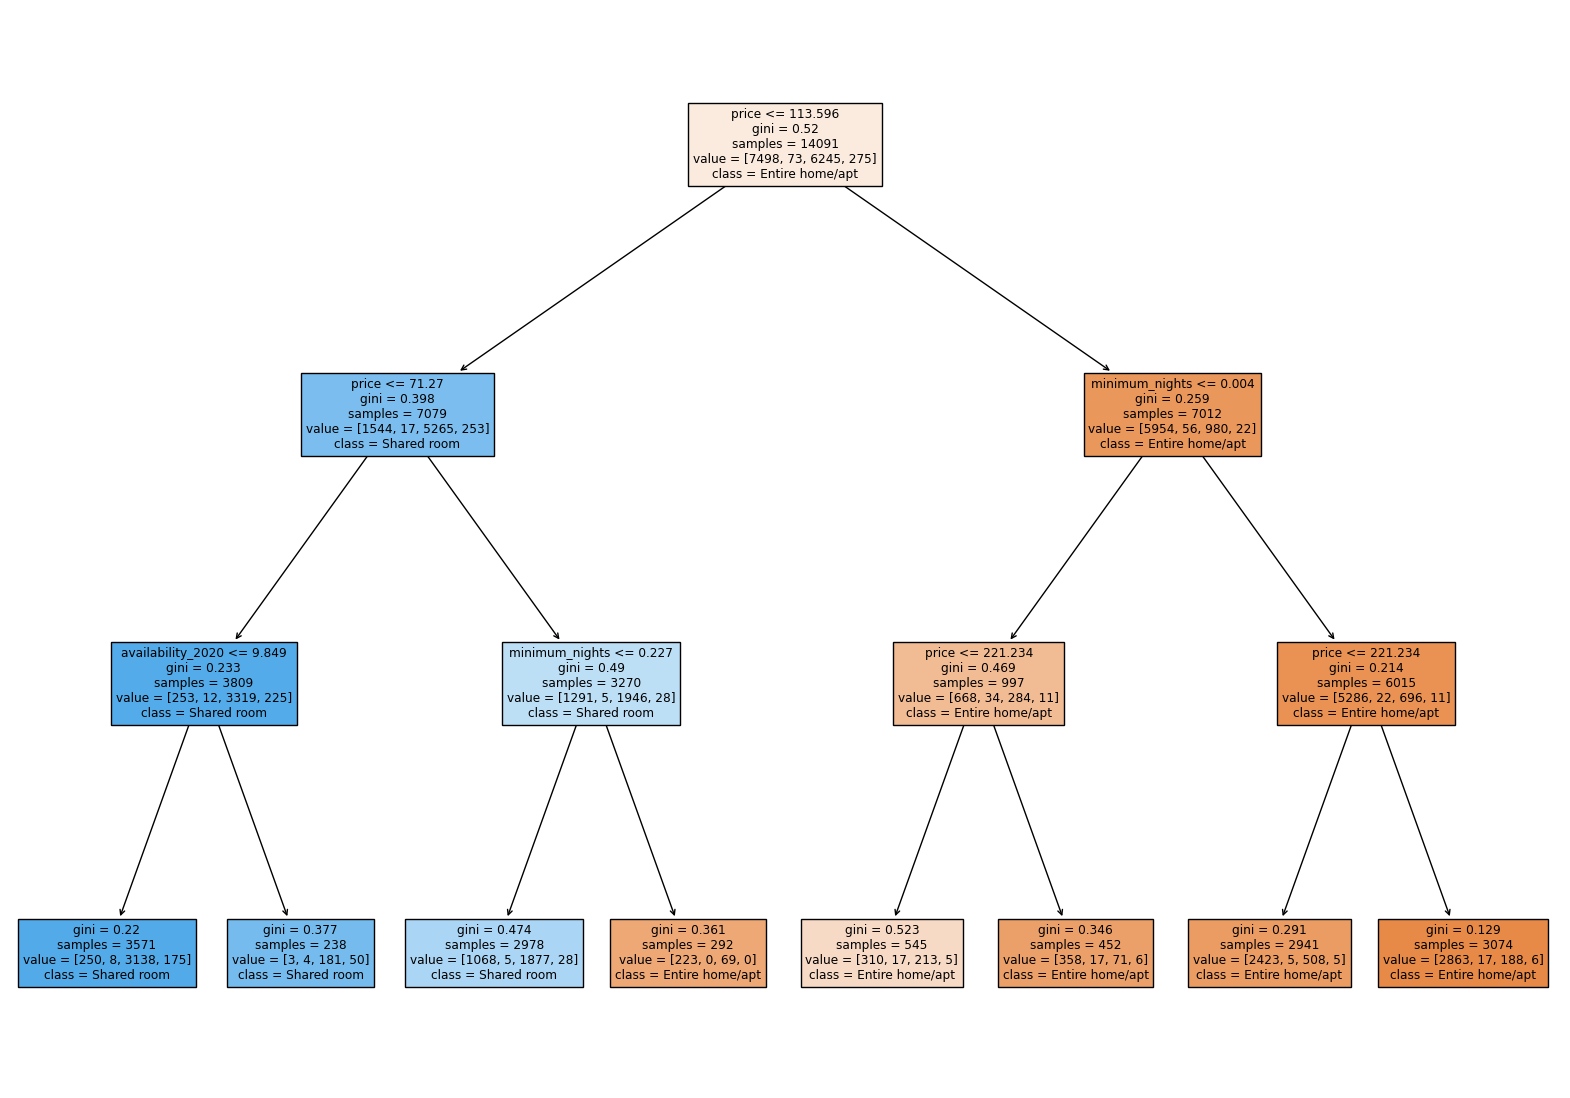

In [502]:
plt.figure(figsize=(20,14))
plot_tree(DecisionTree1, filled=True, feature_names=X.columns, class_names=FrameToWorkOn[prediction_column_name].unique())
plt.show()

Confusion Matrix for Decision Tree 1 :
[[1554    0  353    0]
 [  22    0    5    0]
 [ 229    0 1278    0]
 [   6    0   76    0]]
Accuracy for Decision Tree 1 : 0.8038603462957706
Classification Report for Decision Tree 1 : 
                 precision    recall  f1-score   support

Entire home/apt       0.86      0.81      0.84      1907
     Hotel room       1.00      0.00      0.00        27
   Private room       0.75      0.85      0.79      1507
    Shared room       1.00      0.00      0.00        82

       accuracy                           0.80      3523
      macro avg       0.90      0.42      0.41      3523
   weighted avg       0.81      0.80      0.79      3523



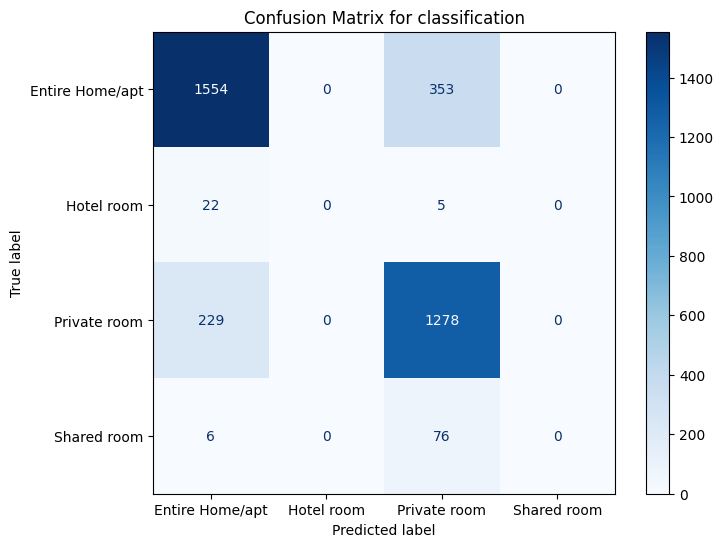

In [503]:
y_pred_DT1 = DecisionTree1.predict(X_test)
classificationReport(y_pred_DT1,DecisionTree1,"Decision Tree 1")

In [504]:
DecisionTree2 = DecisionTreeClassifier(criterion='entropy',
                             max_depth=5)
DecisionTree2=DecisionTree2.fit(X_train,y_train)

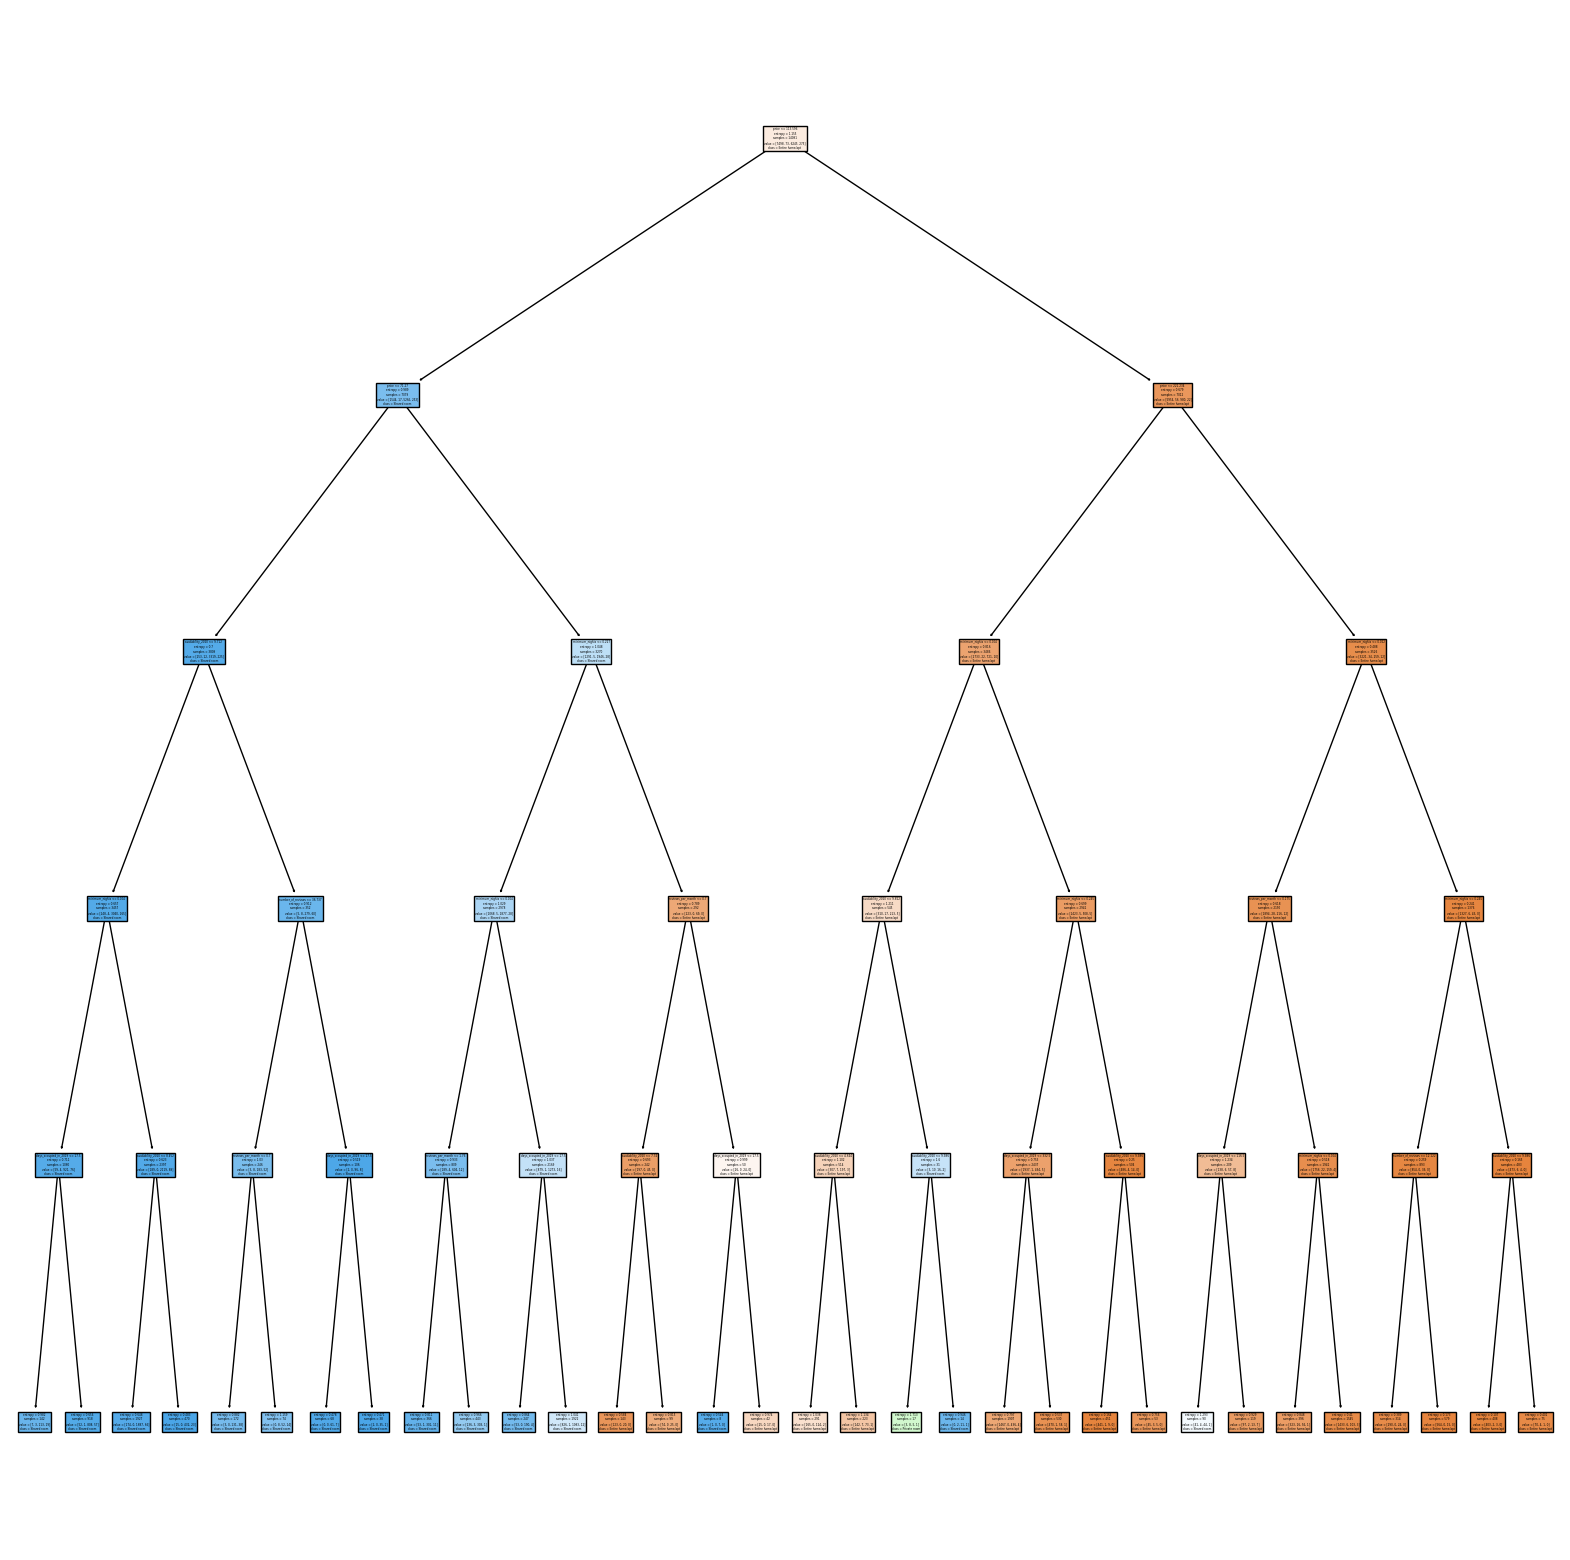

In [505]:
plt.figure(figsize=(20,20))
plot_tree(DecisionTree2, filled=True, feature_names=X.columns, class_names=FrameToWorkOn[prediction_column_name].unique())
plt.show()

Confusion Matrix for Decision Tree 2 :
[[1542    1  364    0]
 [  18    3    6    0]
 [ 221    1 1285    0]
 [   6    0   76    0]]
Accuracy for Decision Tree 2 : 0.8032926483110985
Classification Report for Decision Tree 2 : 
                 precision    recall  f1-score   support

Entire home/apt       0.86      0.81      0.83      1907
     Hotel room       0.60      0.11      0.19        27
   Private room       0.74      0.85      0.79      1507
    Shared room       1.00      0.00      0.00        82

       accuracy                           0.80      3523
      macro avg       0.80      0.44      0.45      3523
   weighted avg       0.81      0.80      0.79      3523



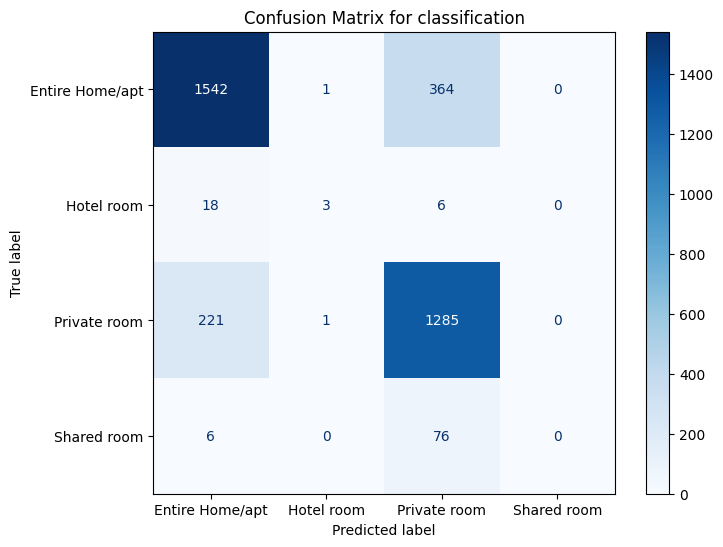

In [506]:
y_pred_DT2 = DecisionTree2.predict(X_test)
classificationReport(y_pred_DT2,DecisionTree2,"Decision Tree 2")

Confusion Matrix for Random Forest 1 :
[[1559    4  343    1]
 [  11    5   11    0]
 [ 326    3 1160   18]
 [   6    0   66   10]]
Accuracy for Random Forest 1 : 0.7760431450468351
Classification Report for Random Forest 1 : 
                 precision    recall  f1-score   support

Entire home/apt       0.82      0.82      0.82      1907
     Hotel room       0.42      0.19      0.26        27
   Private room       0.73      0.77      0.75      1507
    Shared room       0.34      0.12      0.18        82

       accuracy                           0.78      3523
      macro avg       0.58      0.47      0.50      3523
   weighted avg       0.77      0.78      0.77      3523



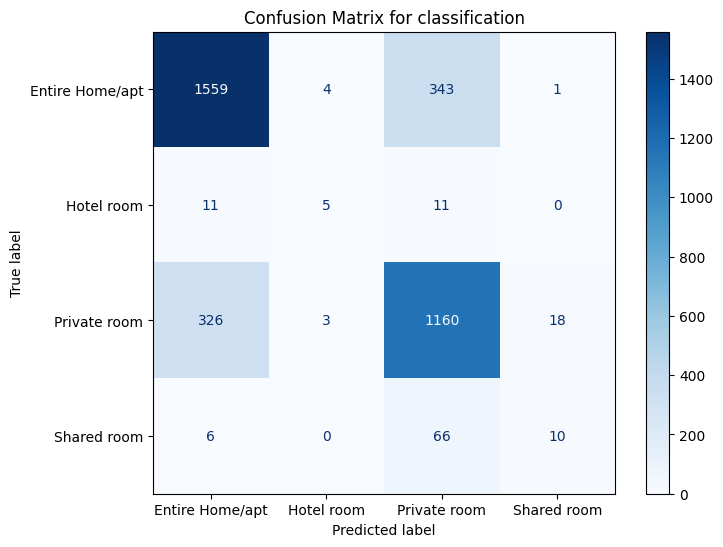

In [507]:
rf_classifier1 = RandomForestClassifier()
rf_classifier1.fit(X_train, y_train)
y_pred_RF1 = rf_classifier1.predict(X_test)
classificationReport(y_pred_RF1,rf_classifier1,"Random Forest 1")

Confusion Matrix for KNN 1 :
[[1576    0  331    0]
 [  17    1    9    0]
 [ 363    1 1139    4]
 [   6    0   68    8]]
Accuracy for KNN 1 : 0.7732046551234744
Classification Report for KNN 1 : 
                 precision    recall  f1-score   support

Entire home/apt       0.80      0.83      0.81      1907
     Hotel room       0.50      0.04      0.07        27
   Private room       0.74      0.76      0.75      1507
    Shared room       0.67      0.10      0.17        82

       accuracy                           0.77      3523
      macro avg       0.68      0.43      0.45      3523
   weighted avg       0.77      0.77      0.76      3523



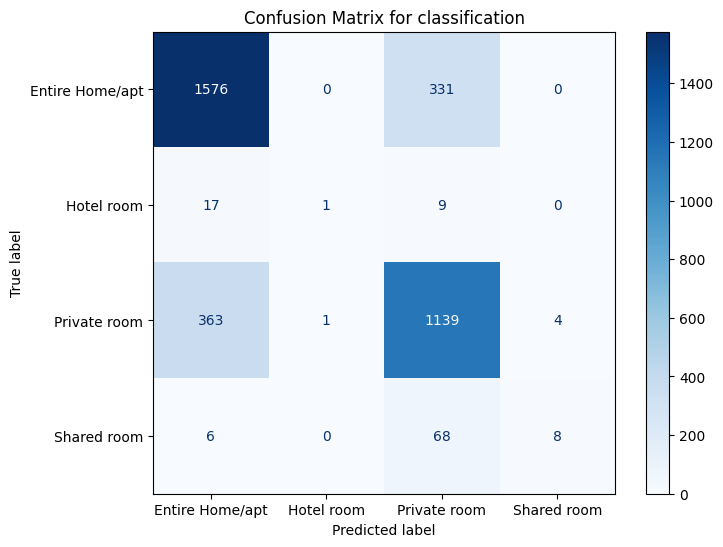

In [508]:
KNN_classifier= KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2 )  
KNN_classifier.fit(X_train,y_train)
y_pred_KNN = KNN_classifier.predict(X_test)
classificationReport(y_pred_KNN,KNN_classifier,"KNN 1")

Confusion Matrix for Naive Bayes 1 :
[[ 966    0  941    0]
 [  14    0   13    0]
 [  64    0 1443    0]
 [   5    0   77    0]]
Accuracy for Naive Bayes 1 : 0.68379222253761
Classification Report for Naive Bayes 1 : 
                 precision    recall  f1-score   support

Entire home/apt       0.92      0.51      0.65      1907
     Hotel room       1.00      0.00      0.00        27
   Private room       0.58      0.96      0.72      1507
    Shared room       1.00      0.00      0.00        82

       accuracy                           0.68      3523
      macro avg       0.88      0.37      0.34      3523
   weighted avg       0.78      0.68      0.66      3523



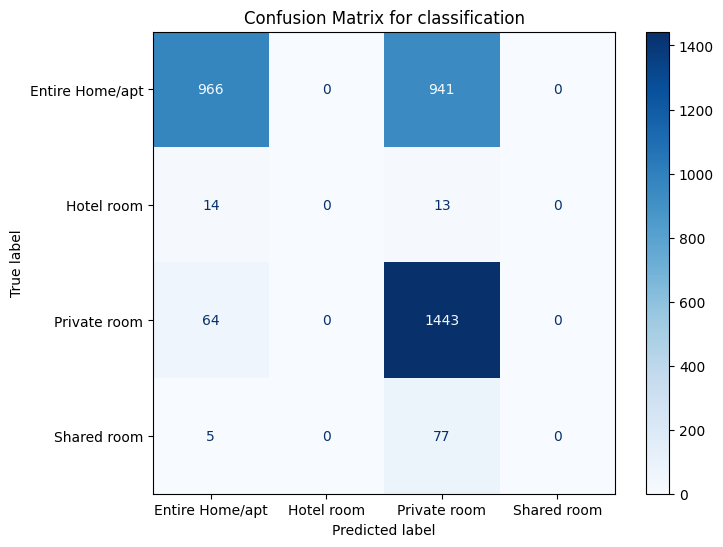

In [509]:
naive_bayes1 = GaussianNB()
naive_bayes1.fit(X_train, y_train)
y_pred_BAY = naive_bayes1.predict(X_test)
classificationReport(y_pred_BAY,naive_bayes1,"Naive Bayes 1")

c:\Users\lidor\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Confusion Matrix for K-Means  :
[[715 377 470 345]
 [  3  14   4   6]
 [900 558  27  22]
 [ 35  44   2   1]]
Accuracy for K-Means  : 0.21487368719841043
Classification Report for K-Means  : 
              precision    recall  f1-score   support

           0       0.43      0.37      0.40      1907
           1       0.01      0.52      0.03        27
           2       0.05      0.02      0.03      1507
           3       0.00      0.01      0.00        82

    accuracy                           0.21      3523
   macro avg       0.13      0.23      0.12      3523
weighted avg       0.26      0.21      0.23      3523



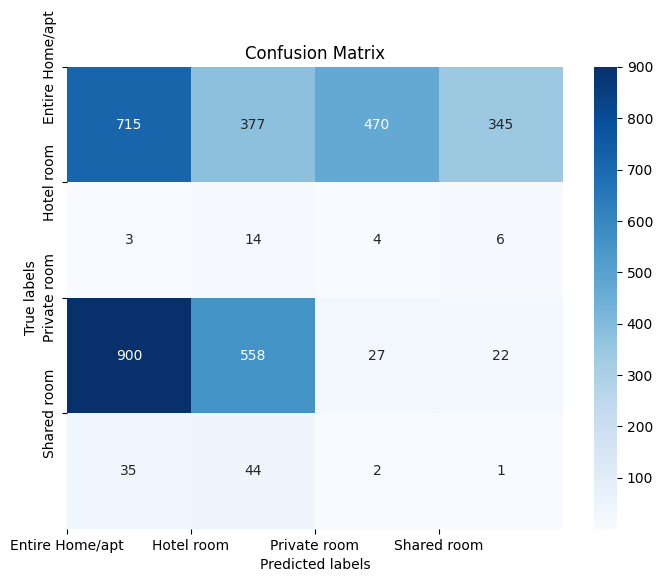

In [510]:
mapping={
    "Entire home/apt":0,
    "Private room":2,
    "Hotel room":1,
    "Shared room":3
}
y_test_Norm=y_test.map(mapping)
className="K-Means "
my_kmeans = KMeans(n_clusters=4).fit(X_train)
# 4. obtain the cluster output
clusters = my_kmeans.predict(X_test) # pass your scaled data here
#classificationReport(clusters,my_kmeans,"K-Means ")
cm = confusion_matrix(y_test_Norm, clusters)
print(f"Confusion Matrix for {className} :")
print(cm)

accuracy_pre = accuracy_score(y_test_Norm, clusters)
print(f'Accuracy for {className} :', accuracy_pre)
# Calculate classification report
report = classification_report(y_test_Norm, clusters,zero_division=1)
print(f"Classification Report for {className} : ")
print(report)
# ShowConfusionMatrixGraph(cm,my_kmeans)
classes=['Entire Home/apt','Hotel room','Private room','Shared room']  
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

# Add labels, title, and axis ticks
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.xticks(ticks=range(len(classes)), labels=classes)
plt.yticks(ticks=range(len(classes)), labels=classes)

# Show the plot
plt.show()


In [511]:
counter=4
FrameToWorkOn.to_csv(f"DataFrames/[NY Realstate Pricing]_clean{counter}.csv",index=True,encoding='utf-8')